In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [14]:
#Load the processed hourly data

try:
    # Load hourly data with basic features already created
    df_hourly = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/data_hourly.csv', index_col='Datetime', parse_dates=True)
    print(f" Hourly data loaded: {len(df_hourly):,} records")
    print(f" Date range: {df_hourly.index.min()} to {df_hourly.index.max()}")
    
    print(f"\n Existing features from Milestone 1:")
    existing_features = list(df_hourly.columns)
    for feat in existing_features:
        print(f"   • {feat}")
    
except FileNotFoundError:
    print(" Error: data_hourly.csv not found!")
    exit()

 Hourly data loaded: 34,589 records
 Date range: 2006-12-16 17:00:00 to 2010-11-26 21:00:00

 Existing features from Milestone 1:
   • Global_active_power
   • Sub_metering_1
   • Sub_metering_2
   • Sub_metering_3
   • hour
   • day
   • month
   • dayofweek
   • quarter
   • is_weekend


In [15]:
# Create a copy for feature engineering
df_features = df_hourly.copy()

# Core device and power columns
device_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
power_col = 'Global_active_power'

In [16]:
#Adding Advanced Time-based Features

print("\n NEW temporal features :")

# Cyclical encoding for hour (helps ML models understand circular nature)
if 'hour_sin' not in df_features.columns:
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    print("    Hour cyclical encoding (hour_sin, hour_cos)")

# Cyclical encoding for month
if 'month_sin' not in df_features.columns:
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    print("    Month cyclical encoding (month_sin, month_cos)")

# Day of year for seasonal patterns
if 'day_of_year' not in df_features.columns:
    df_features['day_of_year'] = df_features.index.dayofyear
    print("    Day of year")

# Week of year
if 'week_of_year' not in df_features.columns:
    df_features['week_of_year'] = df_features.index.isocalendar().week
    print("    Week of year")

# Season (1=Winter, 2=Summer, 3=Monsoon, 4=Fall)
if 'season' not in df_features.columns:
    df_features['season'] = df_features['month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4
    )
    print("    Season (Winter/Summer/Monsoon/Fall)")

# Time of day categories
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    elif 18 <= hour < 22:
        return 3  # Evening
    else:
        return 4  # Night

if 'time_of_day' not in df_features.columns:
    df_features['time_of_day'] = df_features['hour'].apply(get_time_of_day)
    print("    Time of day (Morning/Afternoon/Evening/Night)")

# Business hour indicator
if 'is_business_hour' not in df_features.columns:
    df_features['is_business_hour'] = (
        (df_features['hour'] >= 9) & 
        (df_features['hour'] < 17) & 
        (df_features['dayofweek'] < 5)
    ).astype(int)
    print("    Business hour indicator")


 NEW temporal features :
    Hour cyclical encoding (hour_sin, hour_cos)
    Month cyclical encoding (month_sin, month_cos)
    Day of year
    Week of year
    Season (Winter/Summer/Monsoon/Fall)
    Time of day (Morning/Afternoon/Evening/Night)
    Business hour indicator


In [17]:
#Create Device-Level Aggregated Features

print("\n NEW device-level features:")

# Total consumption across all devices
df_features['total_sub_metering'] = df_features[device_cols].sum(axis=1)
print("    Total sub-metering consumption")

# Percentage contribution of each device
for col in device_cols:
    df_features[f'{col}_percentage'] = (
        df_features[col] / (df_features['total_sub_metering'] + 1e-6) * 100
    )
print("    Device percentage contributions (3 features)")

# Dominant device (which device consumes most)
df_features['dominant_device'] = df_features[device_cols].idxmax(axis=1).apply(
    lambda x: 1 if x == 'Sub_metering_1' else 2 if x == 'Sub_metering_2' else 3
)
print("    Dominant device identifier")

# Device usage intensity (range between max and min)
df_features['device_intensity_range'] = (
    df_features[device_cols].max(axis=1) - df_features[device_cols].min(axis=1)
)
print("    Device usage intensity range")

# Standard deviation of device usage
df_features['device_std'] = df_features[device_cols].std(axis=1)
print("    Device usage standard deviation")

# Unmetered power (difference between total and sub-metering)
df_features['unmetered_power'] = (
    df_features[power_col] * 1000 / 60 - df_features['total_sub_metering']
)
print("    Unmetered power calculation")

# Ratio of each device to total power
for col in device_cols:
    df_features[f'{col}_to_total_ratio'] = (
        df_features[col] / (df_features[power_col] * 1000 / 60 + 1e-6)
    )
print("    Device-to-total power ratios (3 features)")

print(f"\n Device-level features created: 12")


 NEW device-level features:
    Total sub-metering consumption
    Device percentage contributions (3 features)
    Dominant device identifier
    Device usage intensity range
    Device usage standard deviation
    Unmetered power calculation
    Device-to-total power ratios (3 features)

 Device-level features created: 12


In [18]:
#Create lag features

# Lag hours for target variable
lag_hours = [1, 2, 3, 6, 12, 24, 48, 168]  # 1h, 2h, 3h, 6h, 12h, 1day, 2days, 1week

print(f"\n Creating lag features for {power_col}:")
for lag in lag_hours:
    col_name = f'{power_col}_lag_{lag}h'
    df_features[col_name] = df_features[power_col].shift(lag)
    lag_desc = f"{lag}h" if lag < 24 else f"{lag//24}d" if lag < 168 else "1week"
    print(f"    Lag {lag_desc:8s}: {col_name}")

# Lag features for devices (fewer lags to avoid too many features)
print(f"\n Creating lag features for devices:")
device_lags = [1, 24, 168]  # 1h, 1day, 1week
for device in device_cols:
    for lag in device_lags:
        col_name = f'{device}_lag_{lag}h'
        df_features[col_name] = df_features[device].shift(lag)
    print(f"    {device}: lags for 1h, 1day, 1week")

print(f"\n Total lag features created: {len(lag_hours) + len(device_cols) * len(device_lags)}")



 Creating lag features for Global_active_power:
    Lag 1h      : Global_active_power_lag_1h
    Lag 2h      : Global_active_power_lag_2h
    Lag 3h      : Global_active_power_lag_3h
    Lag 6h      : Global_active_power_lag_6h
    Lag 12h     : Global_active_power_lag_12h
    Lag 1d      : Global_active_power_lag_24h
    Lag 2d      : Global_active_power_lag_48h
    Lag 1week   : Global_active_power_lag_168h

 Creating lag features for devices:
    Sub_metering_1: lags for 1h, 1day, 1week
    Sub_metering_2: lags for 1h, 1day, 1week
    Sub_metering_3: lags for 1h, 1day, 1week

 Total lag features created: 17


In [19]:
#Create rolling window features

# Rolling windows (hours)
windows = [3, 6, 12, 24, 168]  # 3h, 6h, 12h, 1day, 1week

print(f"\n Creating rolling statistics for {power_col}:")

for window in windows:
    # Rolling mean (moving average)
    df_features[f'{power_col}_rolling_mean_{window}h'] = (
        df_features[power_col].rolling(window=window, min_periods=1).mean()
    )
    
    # Rolling standard deviation
    df_features[f'{power_col}_rolling_std_{window}h'] = (
        df_features[power_col].rolling(window=window, min_periods=1).std()
    )
    
    # Rolling min
    df_features[f'{power_col}_rolling_min_{window}h'] = (
        df_features[power_col].rolling(window=window, min_periods=1).min()
    )
    
    # Rolling max
    df_features[f'{power_col}_rolling_max_{window}h'] = (
        df_features[power_col].rolling(window=window, min_periods=1).max()
    )
    
    window_desc = f"{window}h" if window < 24 else f"{window//24}d" if window < 168 else "1week"
    print(f"    Window {window_desc:8s}: mean, std, min, max")

# Rolling averages for devices (24h window only)
print(f"\n Creating 24h rolling averages for devices:")
for device in device_cols:
    df_features[f'{device}_rolling_mean_24h'] = (
        df_features[device].rolling(window=24, min_periods=1).mean()
    )
    print(f"    {device}: 24h rolling mean")

print(f"\n Total rolling features created: {len(windows) * 4 + len(device_cols)}")


 Creating rolling statistics for Global_active_power:
    Window 3h      : mean, std, min, max
    Window 6h      : mean, std, min, max
    Window 12h     : mean, std, min, max
    Window 1d      : mean, std, min, max
    Window 1week   : mean, std, min, max

 Creating 24h rolling averages for devices:
    Sub_metering_1: 24h rolling mean
    Sub_metering_2: 24h rolling mean
    Sub_metering_3: 24h rolling mean

 Total rolling features created: 23


In [20]:
#Creating Advanced Time Series Features

print("\n Advanced features:")

# Difference features (change from previous period)
df_features[f'{power_col}_diff_1h'] = df_features[power_col].diff(1)
df_features[f'{power_col}_diff_24h'] = df_features[power_col].diff(24)
print("    Difference features (1h, 24h)")

# Rate of change (percentage)
df_features[f'{power_col}_pct_change_1h'] = df_features[power_col].pct_change(1) * 100
df_features[f'{power_col}_pct_change_24h'] = df_features[power_col].pct_change(24) * 100
print("    Percentage change (1h, 24h)")

# Exponential moving average (gives more weight to recent values)
df_features[f'{power_col}_ema_12h'] = (
    df_features[power_col].ewm(span=12, adjust=False).mean()
)
df_features[f'{power_col}_ema_24h'] = (
    df_features[power_col].ewm(span=24, adjust=False).mean()
)
print("    Exponential moving averages (12h, 24h)")

# Momentum (current - moving average)
df_features[f'{power_col}_momentum_24h'] = (
    df_features[power_col] - df_features[f'{power_col}_rolling_mean_24h']
)
print("    Momentum (deviation from 24h average)")

# Volatility (rolling standard deviation as percentage of mean)
df_features[f'{power_col}_volatility_24h'] = (
    df_features[f'{power_col}_rolling_std_24h'] / 
    (df_features[f'{power_col}_rolling_mean_24h'] + 1e-6) * 100
)
print("    Volatility (24h)")

print(f"\n Advanced time series features created: 9")


 Advanced features:
    Difference features (1h, 24h)
    Percentage change (1h, 24h)
    Exponential moving averages (12h, 24h)
    Momentum (deviation from 24h average)
    Volatility (24h)

 Advanced time series features created: 9


In [21]:
#Handling Missing Values

# Count missing values
missing_before = df_features.isnull().sum().sum()
print(f"\n Missing values before handling: {missing_before:,}")
print(f"   (Caused by lag and rolling window operations)")

# Strategy: Drop first 168 rows (1 week) where lag features are NaN
rows_before = len(df_features)
df_features_clean = df_features.iloc[168:].copy()  # Skip first week
rows_after = len(df_features_clean)

print(f"\n Dropped first {rows_before - rows_after} rows (1 week)")

# Forward/backward fill any remaining NaN
df_features_clean = df_features_clean.fillna(method='ffill').fillna(method='bfill')

missing_after = df_features_clean.isnull().sum().sum()
print(f" Missing values after handling: {missing_after:,}")
print(f" Final dataset: {len(df_features_clean):,} records")


 Missing values before handling: 21,705
   (Caused by lag and rolling window operations)

 Dropped first 168 rows (1 week)
 Missing values after handling: 0
 Final dataset: 34,421 records


In [22]:
# Feature Engineering Summary and Statistics

# Count features by category
original_features = list(df_hourly.columns)
new_features = [col for col in df_features_clean.columns if col not in original_features]

# Categorize new features
temporal_new = [col for col in new_features if any(
    x in col for x in ['sin', 'cos', 'season', 'time_of_day', 'business', 'day_of_year', 'week_of_year']
)]
lag_features = [col for col in new_features if 'lag' in col]
rolling_features = [col for col in new_features if 'rolling' in col or 'ema' in col]
device_features = [col for col in new_features if any(
    x in col for x in ['percentage', 'dominant', 'intensity', 'unmetered', 'ratio', 'device_std', 'total_sub']
)]
advanced_features = [col for col in new_features if any(
    x in col for x in ['diff', 'pct_change', 'momentum', 'volatility']
)]

print(f"\n Feature Engineering Statistics:")
print(f"   • Original features (Milestone 1): {len(original_features)}")
print(f"   • NEW features created: {len(new_features)}")
print(f"   • Total features: {len(df_features_clean.columns)}")

print(f"\n NEW Features by Category:")
print(f"   • Advanced temporal: {len(temporal_new)}")
print(f"   • Lag features: {len(lag_features)}")
print(f"   • Rolling window: {len(rolling_features)}")
print(f"   • Device aggregations: {len(device_features)}")
print(f"   • Advanced time series: {len(advanced_features)}")


 Feature Engineering Statistics:
   • Original features (Milestone 1): 10
   • NEW features created: 68
   • Total features: 78

 NEW Features by Category:
   • Advanced temporal: 9
   • Lag features: 17
   • Rolling window: 25
   • Device aggregations: 11
   • Advanced time series: 6


In [23]:
# Saving Engineeered Features

# Save complete feature set
df_features_clean.to_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/data_features_engineered.csv')
print(" Saved: data_features_engineered.csv")

# Save feature catalog
feature_catalog = pd.DataFrame({
    'Feature': df_features_clean.columns,
    'Source': ['Milestone 1' if col in original_features else 'Milestone 2' for col in df_features_clean.columns],
    'Category': [
        'Original' if col in original_features else
        'Temporal' if col in temporal_new else
        'Lag' if col in lag_features else
        'Rolling' if col in rolling_features else
        'Device' if col in device_features else
        'Advanced' for col in df_features_clean.columns
    ]
})
feature_catalog.to_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/feature_catalog.csv', index=False)
print(" Saved: feature_catalog.csv")

 Saved: data_features_engineered.csv
 Saved: feature_catalog.csv


 Visualization saved as 'module3_feature_engineering.png'


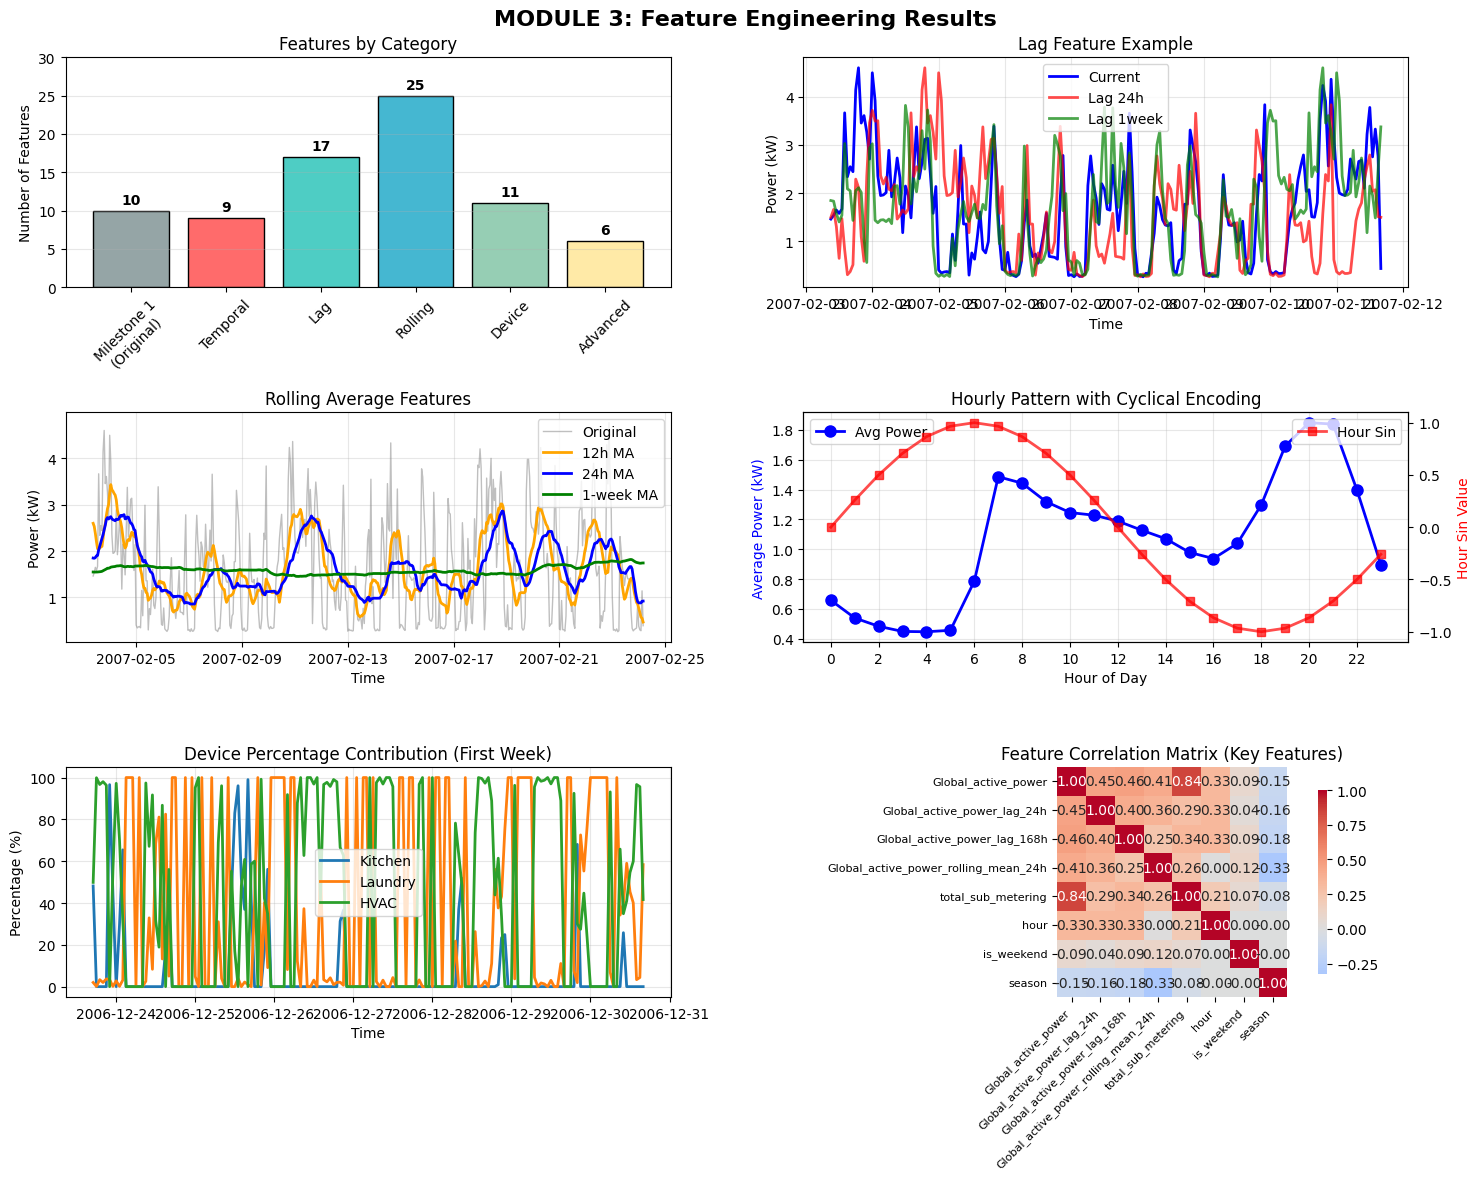

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('MODULE 3: Feature Engineering Results', fontsize=16, fontweight='bold')

# Plot 1: Feature count by category
ax1 = axes[0, 0]
categories = ['Milestone 1\n(Original)', 'Temporal', 'Lag', 'Rolling', 'Device', 'Advanced']
counts = [len(original_features), len(temporal_new), len(lag_features), 
        len(rolling_features), len(device_features), len(advanced_features)]
colors = ['#95A5A6', '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = ax1.bar(categories, counts, color=colors, edgecolor='black')
ax1.set_title('Features by Category')
ax1.set_ylabel('Number of Features')
ax1.set_ylim(0, max(counts) + 5)
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Sample lag features demonstration
ax2 = axes[0, 1]
sample_range = range(1000, 1200)
ax2.plot(df_features_clean.index[sample_range], 
        df_features_clean[power_col].iloc[sample_range], 
        label='Current', linewidth=2, color='blue')
ax2.plot(df_features_clean.index[sample_range], 
        df_features_clean[f'{power_col}_lag_24h'].iloc[sample_range], 
        label='Lag 24h', linewidth=2, alpha=0.7, color='red')
ax2.plot(df_features_clean.index[sample_range], 
        df_features_clean[f'{power_col}_lag_168h'].iloc[sample_range], 
        label='Lag 1week', linewidth=2, alpha=0.7, color='green')
ax2.set_title('Lag Feature Example')
ax2.set_xlabel('Time')
ax2.set_ylabel('Power (kW)')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Rolling averages comparison
ax3 = axes[1, 0]
sample_range = range(1000, 1500)
ax3.plot(df_features_clean.index[sample_range], 
        df_features_clean[power_col].iloc[sample_range], 
        label='Original', linewidth=1, alpha=0.5, color='gray')
ax3.plot(df_features_clean.index[sample_range], 
        df_features_clean[f'{power_col}_rolling_mean_12h'].iloc[sample_range], 
        label='12h MA', linewidth=2, color='orange')
ax3.plot(df_features_clean.index[sample_range], 
        df_features_clean[f'{power_col}_rolling_mean_24h'].iloc[sample_range], 
        label='24h MA', linewidth=2, color='blue')
ax3.plot(df_features_clean.index[sample_range], 
        df_features_clean[f'{power_col}_rolling_mean_168h'].iloc[sample_range], 
        label='1-week MA', linewidth=2, color='green')
ax3.set_title('Rolling Average Features')
ax3.set_xlabel('Time')
ax3.set_ylabel('Power (kW)')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Hourly pattern with cyclical encoding
ax4 = axes[1, 1]
hourly_avg = df_features_clean.groupby('hour')[power_col].mean()
ax4_twin = ax4.twinx()
ax4.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, 
        markersize=8, color='blue', label='Avg Power')
ax4_twin.plot(hourly_avg.index, 
            df_features_clean.groupby('hour')['hour_sin'].mean().values,
            marker='s', linewidth=2, markersize=6, color='red', 
            alpha=0.7, label='Hour Sin')
ax4.set_title('Hourly Pattern with Cyclical Encoding')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Average Power (kW)', color='blue')
ax4_twin.set_ylabel('Hour Sin Value', color='red')
ax4.set_xticks(range(0, 24, 2))
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(alpha=0.3)

# Plot 5: Device percentage contribution over time
ax5 = axes[2, 0]
sample_range = range(0, 168)  # First week
for i, device in enumerate(device_cols, 1):
    device_name = 'Kitchen' if i == 1 else 'Laundry' if i == 2 else 'HVAC'
    ax5.plot(df_features_clean.index[sample_range],
            df_features_clean[f'{device}_percentage'].iloc[sample_range],
            label=device_name, linewidth=2)
ax5.set_title('Device Percentage Contribution (First Week)')
ax5.set_xlabel('Time')
ax5.set_ylabel('Percentage (%)')
ax5.legend()
ax5.grid(alpha=0.3)

# Plot 6: Feature correlation heatmap (sample)
ax6 = axes[2, 1]
# Select important features for correlation
important_features = [
    power_col,
    f'{power_col}_lag_24h',
    f'{power_col}_lag_168h',
    f'{power_col}_rolling_mean_24h',
    'total_sub_metering',
    'hour',
    'is_weekend',
    'season'
]
# Filter to only existing columns
important_features = [f for f in important_features if f in df_features_clean.columns]
corr_matrix = df_features_clean[important_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=ax6, cbar_kws={'shrink': 0.8})
ax6.set_title('Feature Correlation Matrix (Key Features)')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax6.set_yticklabels(ax6.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('C:/Users/battu/Documents/SmartEnergyML/notebooks/visualizations/module3_feature_engineering.png', dpi=300, bbox_inches='tight')
print(" Visualization saved as 'module3_feature_engineering.png'")
plt.show()
